In [1]:
## Ran notebook multiple times to obtain txt and csv files for separate CEOs

# Library Imports
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import config
import sys
import jsonpickle
import os

plt.style.use('fivethirtyeight')

In [2]:
# Set variables for API keys and tokens
ak = config.apiKey
ask = config.apiSecretKey

## Additional tokens if needed ##
    # at = config.accessToken
    # ats = config.accessTokenSecret
## --------------------------- ##

# Create authentication object
authenticate = tweepy.AppAuthHandler(ak, ask)
authenticate.secure = True

# Make the API call wait when it hits the
# rate limit then continue upon expiry of the window 
api = tweepy.API(authenticate, wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)

# Set condition for failed authentication
if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

In [7]:
# Base source: https://bit.ly/2WSO8El

searchQuery = 'Bill Gates' # pull tweets that would come up if this was the search term
retweet_filter = '-filter:retweets' # needed to pass over retweets
tweetsPerQry = 100 # Prevent hitting the API limit
fileName = 'GatesTweets.txt' # file name to store tweets in
sinceId = None

max_id = -1
maxTweets = 50000 # Max amount of tweets to scrape

tweetCount = 0 # Initializer

print(f"Downloading max {maxTweets} tweets")

# Scrape and write tweets to txt file
with open(fileName, 'w') as f:
    # Scrape as many tweets as possible up until the declared maximum
    while tweetCount < maxTweets:
        try:
            # Get tweets starting with the most recently available
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry, lang='en')
                else:
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry, lang='en',
                                            since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry, lang='en',
                                            max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry, lang='en',
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                print("No more tweets found")
                break
                
            for tweet in new_tweets:
                
                # only use tweet._json rather than tweet.json['text'] to get full json for each tweet
                f.write(jsonpickle.encode(tweet._json['text'],
                                          unpicklable=False) + '\n') # Only pull tweet text to minimize file size
            tweetCount += len(new_tweets)
            max_id = new_tweets[-1].id
            
        except tweepy.TweepError as e:
            # Exit upon error
            print("some error : " + str(e))
            break

print (f"Downloaded {tweetCount} tweets, Saved to {fileName}")

No more tweets found
Downloaded 38540 tweets, Saved to GatesTweets.txt


In [8]:
# Create dataframe containing tweets
df = pd.read_fwf('GatesTweets.txt', sep = '\n', header = None)

df.columns = ['Tweets']

# Clean tweets
def cleanTxt(text):
    
    text = re.sub(r'@[A-Za-z0-9]+','',text) # Remove @mentions
    text = re.sub(r'#','',text) # Remove hashtag symbols
    text = re.sub(r'RT[\s]+','',text) # Remove retweets
    text = re.sub(r'https?:\/\/\S+','',text) # Remove hyperlink
    text = re.sub(r':','',text) # Remove colons
    text = re.sub(r'\\u[A-Za-z0-9]+','',text) # Remove unicode
    text = re.sub(r'"','',text) # Remove quotation marks
    text = re.sub(r'Bill','',text) # Remove Bill
    text = re.sub(r'bill','',text) # Remove bill
    text = re.sub(r'Gates','',text) # Remove Gates
    text = re.sub(r'gates','',text) # Remove gates
    return text

df['Tweets'] = df['Tweets'].apply(cleanTxt)

df

,Tweets
0,My momma just tried to tell me drives a For...
1,Final Form
2,I could tell my kids spinned on me in queens...
3,Give it to he'll find a way of turning it i...
4,Don't trust any lab that and Melinda foun...
...,...
38535,I enjoy finding conspiracy websites with discu...
38536,the Virus Tax Guru. He says he's giving io...
38537,I believe optimism is important &amp; posit...
38538,This is the \very best case\ scenario for wh...


In [9]:
# Create a function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create two new columns
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

# Compute negative, neutral and positive analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

# Assign analysis to a new column
df['Analysis'] = df['Polarity'].apply(getAnalysis)

# Insert CEO's name into first column for usage in
# Tableau analysis (combination of CSV files)
df.insert(0,'CEO','Bill Gates')

df

,CEO,Tweets,Subjectivity,Polarity,Analysis
0,Bill Gates,My momma just tried to tell me drives a For...,0.900000,0.100,Positive
1,Bill Gates,Final Form,1.000000,0.000,Neutral
2,Bill Gates,I could tell my kids spinned on me in queens...,0.000000,0.000,Neutral
3,Bill Gates,Give it to he'll find a way of turning it i...,0.000000,0.000,Neutral
4,Bill Gates,Don't trust any lab that and Melinda foun...,0.333333,0.250,Positive
...,...,...,...,...,...
38535,Bill Gates,I enjoy finding conspiracy websites with discu...,0.450000,0.200,Positive
38536,Bill Gates,the Virus Tax Guru. He says he's giving io...,0.000000,0.000,Neutral
38537,Bill Gates,I believe optimism is important &amp; posit...,0.770000,0.280,Positive
38538,Bill Gates,This is the \very best case\ scenario for wh...,0.475000,0.575,Positive


In [10]:
# Export dataframe to CSV
df.to_csv('GatesTweets.csv', encoding='utf-8', index=False)

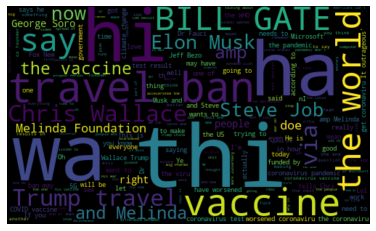

In [11]:
# Plot Word Cloud
allWords = ' '.join([twts for twts in df['Tweets']])
wordCloud = WordCloud(width = 500, height = 300,
                      random_state = 21,
                      max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [8]:
## Plot polarity and subjectivity ----- this was more effective in Tableau

# plt.figure(figsize = (8,6))

# for i in range(0, df.shape[0]):
#     plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color = 'Blue', alpha = 0.5)
    
# plt.title('Sentiment Analysis')
# plt.xlabel('Polarity')
# plt.ylabel('Subjectivity')
# plt.show()

In [12]:
# Get percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']
ptweetspercent = round((ptweets.shape[0] / df.shape[0]*100), 1)
print(f'Positive Tweet %: {ptweetspercent}')

# Get percentage of negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']
ntweetspercent = round((ntweets.shape[0] / df.shape[0]*100), 1)
print(f'Negative Tweet %: {ntweetspercent}')

# Get percentage of neutral tweets
rtweets = df[df.Analysis == 'Neutral']
rtweets = rtweets['Tweets']
rtweetspercent = round((rtweets.shape[0] / df.shape[0]*100), 1)
print(f'Neutral Tweet %: {rtweetspercent}')

Positive Tweet %: 28.7
Negative Tweet %: 19.0
Neutral Tweet %: 52.3


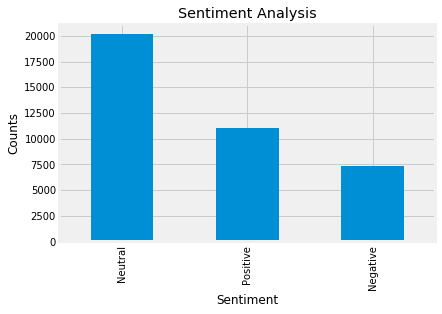

In [13]:
# Show value counts

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')

df['Analysis'].value_counts().plot(kind='bar')
plt.show()

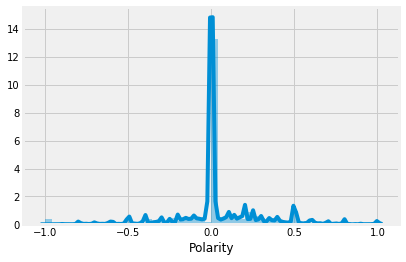

In [14]:
# Show frequency of different sentiments
sns.distplot(df['Polarity'])